# CNN 2D layers for three-second splits

~80% validation accuracy

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import pandas as pd
import numpy as np

In [2]:
import pickle

infile = open("Preprocessed/mfcc_list_time-series_639450_10_60",'rb')
mfcc_list = pickle.load(infile)
infile.close()

In [3]:
df = pd.read_csv("Data/features_30_sec.csv")

In [4]:
df['labels'] = range(0, 1000)

In [5]:
mfcc_list = mfcc_list.merge(df, on="labels", how="left")

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mfcc_list.mfcc, mfcc_list.label, test_size=0.2, random_state=42
)

y_test_keep = y_test

In [7]:
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
y_train = le.fit_transform(y_train.values)
y_test = le.transform(y_test.values)

In [8]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.hidden_size = 1290
        drp = 0.1
        n_classes = 10
        self.fc1 = nn.Linear(125*60, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
        # self.softmax = nn.Softmax(n_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        fc1 = self.dropout(self.relu(self.fc1(x)))
        fc2 = self.dropout(self.relu(self.fc2(fc1)))
        fc3 = self.dropout(self.relu(self.fc3(fc2)))
        fc4 = self.dropout(self.relu(self.fc4(fc3)))
        fc5 = self.dropout(self.relu(self.fc5(fc4)))
        out = self.out(fc5)
        return out

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        drp = 0.1
        n_classes = len(le.classes_)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        
        self.cnn_layer1 = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(drp),
            # Layer 2
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(drp),
            # Layer 3
            nn.Conv2d(32, 32, kernel_size=(3, 4), stride=2, padding=0),
            # Out: 62, 29
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(4, 3), stride=2, padding=0),
            # Out: 30, 14
            nn.Dropout(drp),
        )
        
        # self.cnn_layer2 = nn.Sequential(
        #     # Layer 1
        #     nn.Conv1d(40, 40, kernel_size=5, stride=1, padding=2),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        
        # self.cnn_layer2 = nn.Sequential(
        #     # Layer 2
        #     nn.Conv1d(40, 40, kernel_size=249, stride=1, padding=124),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        # self.cnn_layer3 = nn.Sequential(
        #     # Layer 3
        #     nn.Conv1d(40, 40, kernel_size=125, stride=1, padding=62),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        # self.cnn_layer4 = nn.Sequential(
        #     # Layer 4
        #     nn.Conv1d(40, 40, kernel_size=59, stride=1, padding=29),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp)
        # )
        
        self.fc1 = nn.Linear(30 * 14 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
        self.directout = nn.Linear(512, n_classes)

    def forward(self, x):
        # x = x.view(x.shape[0], 40, 125)
        x = torch.unsqueeze(x, dim = 1)
        out1 = self.cnn_layer1(x)
        # out1 = self.cnn_layer1(out1)
        # out2 = self.cnn_layer2(x)
        # out3 = self.cnn_layer3(x)
        # out4 = self.cnn_layer4(x)
        # full_out = torch.cat([out1, out2], dim=1)
        # full_out = full_out.view(full_out.size(0), -1)
        x = torch.flatten(out1, start_dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        out = self.out(x)
        return out

In [10]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = F.softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    _, y_test_tags = torch.max(y_test, dim = 1) 
    
    correct_pred = (y_pred_tags == y_test_tags).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return y_pred_softmax, acc

In [20]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 50
batch_size = 32
model = CNN()
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001
)

model.to(device)

# Load train and test in CUDA Memory
x_train = torch.tensor(X_train.values.tolist(), dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
x_cv = torch.tensor(X_test.values.tolist(), dtype=torch.float).to(device)
y_cv = torch.tensor(y_test, dtype=torch.float).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train_tensor)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.0
    accuracy = []
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # # Casting
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.type(torch.LongTensor)
        # y_batch = y_batch.to(device)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        _, acc = multi_acc(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
        accuracy.append(acc.item())

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.0
    val_accuracy = []
    val_preds = np.zeros((len(x_cv), 10))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        # Casting
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.type(torch.LongTensor)
        # y_batch = y_batch.to(device)
        # Detach
        y_pred = model(x_batch).detach()
        val_pred, val_acc = multi_acc(y_pred, y_batch)
        val_preds[i * batch_size:(i+1) * batch_size] = val_pred.cpu()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        val_accuracy.append(val_acc.item())

    # Check Accuracy
    # val_accuracy = sum(val_preds.argmax(axis=1) == y_test) / len(y_test)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print(
        "Epoch {}/{} \t loss={:.4f} \t acc={:.2f}% \t val_loss={:.4f} \t val_acc={:.2f}% \t time={:.2f}s".format(
            epoch + 1, n_epochs, avg_loss, np.mean(accuracy), avg_val_loss, np.mean(val_accuracy), elapsed_time
        )
    )


Epoch 1/50 	 loss=61.0172 	 acc=28.68% 	 val_loss=50.9829 	 val_acc=40.24% 	 time=5.55s
Epoch 2/50 	 loss=46.6489 	 acc=46.65% 	 val_loss=45.2961 	 val_acc=46.46% 	 time=5.52s
Epoch 3/50 	 loss=41.6217 	 acc=52.90% 	 val_loss=41.2855 	 val_acc=52.17% 	 time=5.53s
Epoch 4/50 	 loss=37.3904 	 acc=58.78% 	 val_loss=42.4914 	 val_acc=54.40% 	 time=5.54s
Epoch 5/50 	 loss=34.2047 	 acc=62.33% 	 val_loss=41.9604 	 val_acc=56.16% 	 time=5.54s
Epoch 6/50 	 loss=32.0840 	 acc=64.74% 	 val_loss=36.1542 	 val_acc=61.54% 	 time=5.55s
Epoch 7/50 	 loss=29.0955 	 acc=68.91% 	 val_loss=37.9349 	 val_acc=59.22% 	 time=5.55s
Epoch 8/50 	 loss=27.2806 	 acc=70.90% 	 val_loss=36.0709 	 val_acc=62.67% 	 time=5.55s
Epoch 9/50 	 loss=24.7370 	 acc=73.72% 	 val_loss=28.5178 	 val_acc=69.08% 	 time=5.55s
Epoch 10/50 	 loss=23.5675 	 acc=75.20% 	 val_loss=26.0854 	 val_acc=72.30% 	 time=5.55s
Epoch 11/50 	 loss=21.8421 	 acc=77.02% 	 val_loss=30.4715 	 val_acc=66.37% 	 time=5.56s
Epoch 12/50 	 loss=19.7717 	 a

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_graph(epochs):
    plt.figure(figsize=(12,12), dpi=600)
    sns.set_style("ticks")
    plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

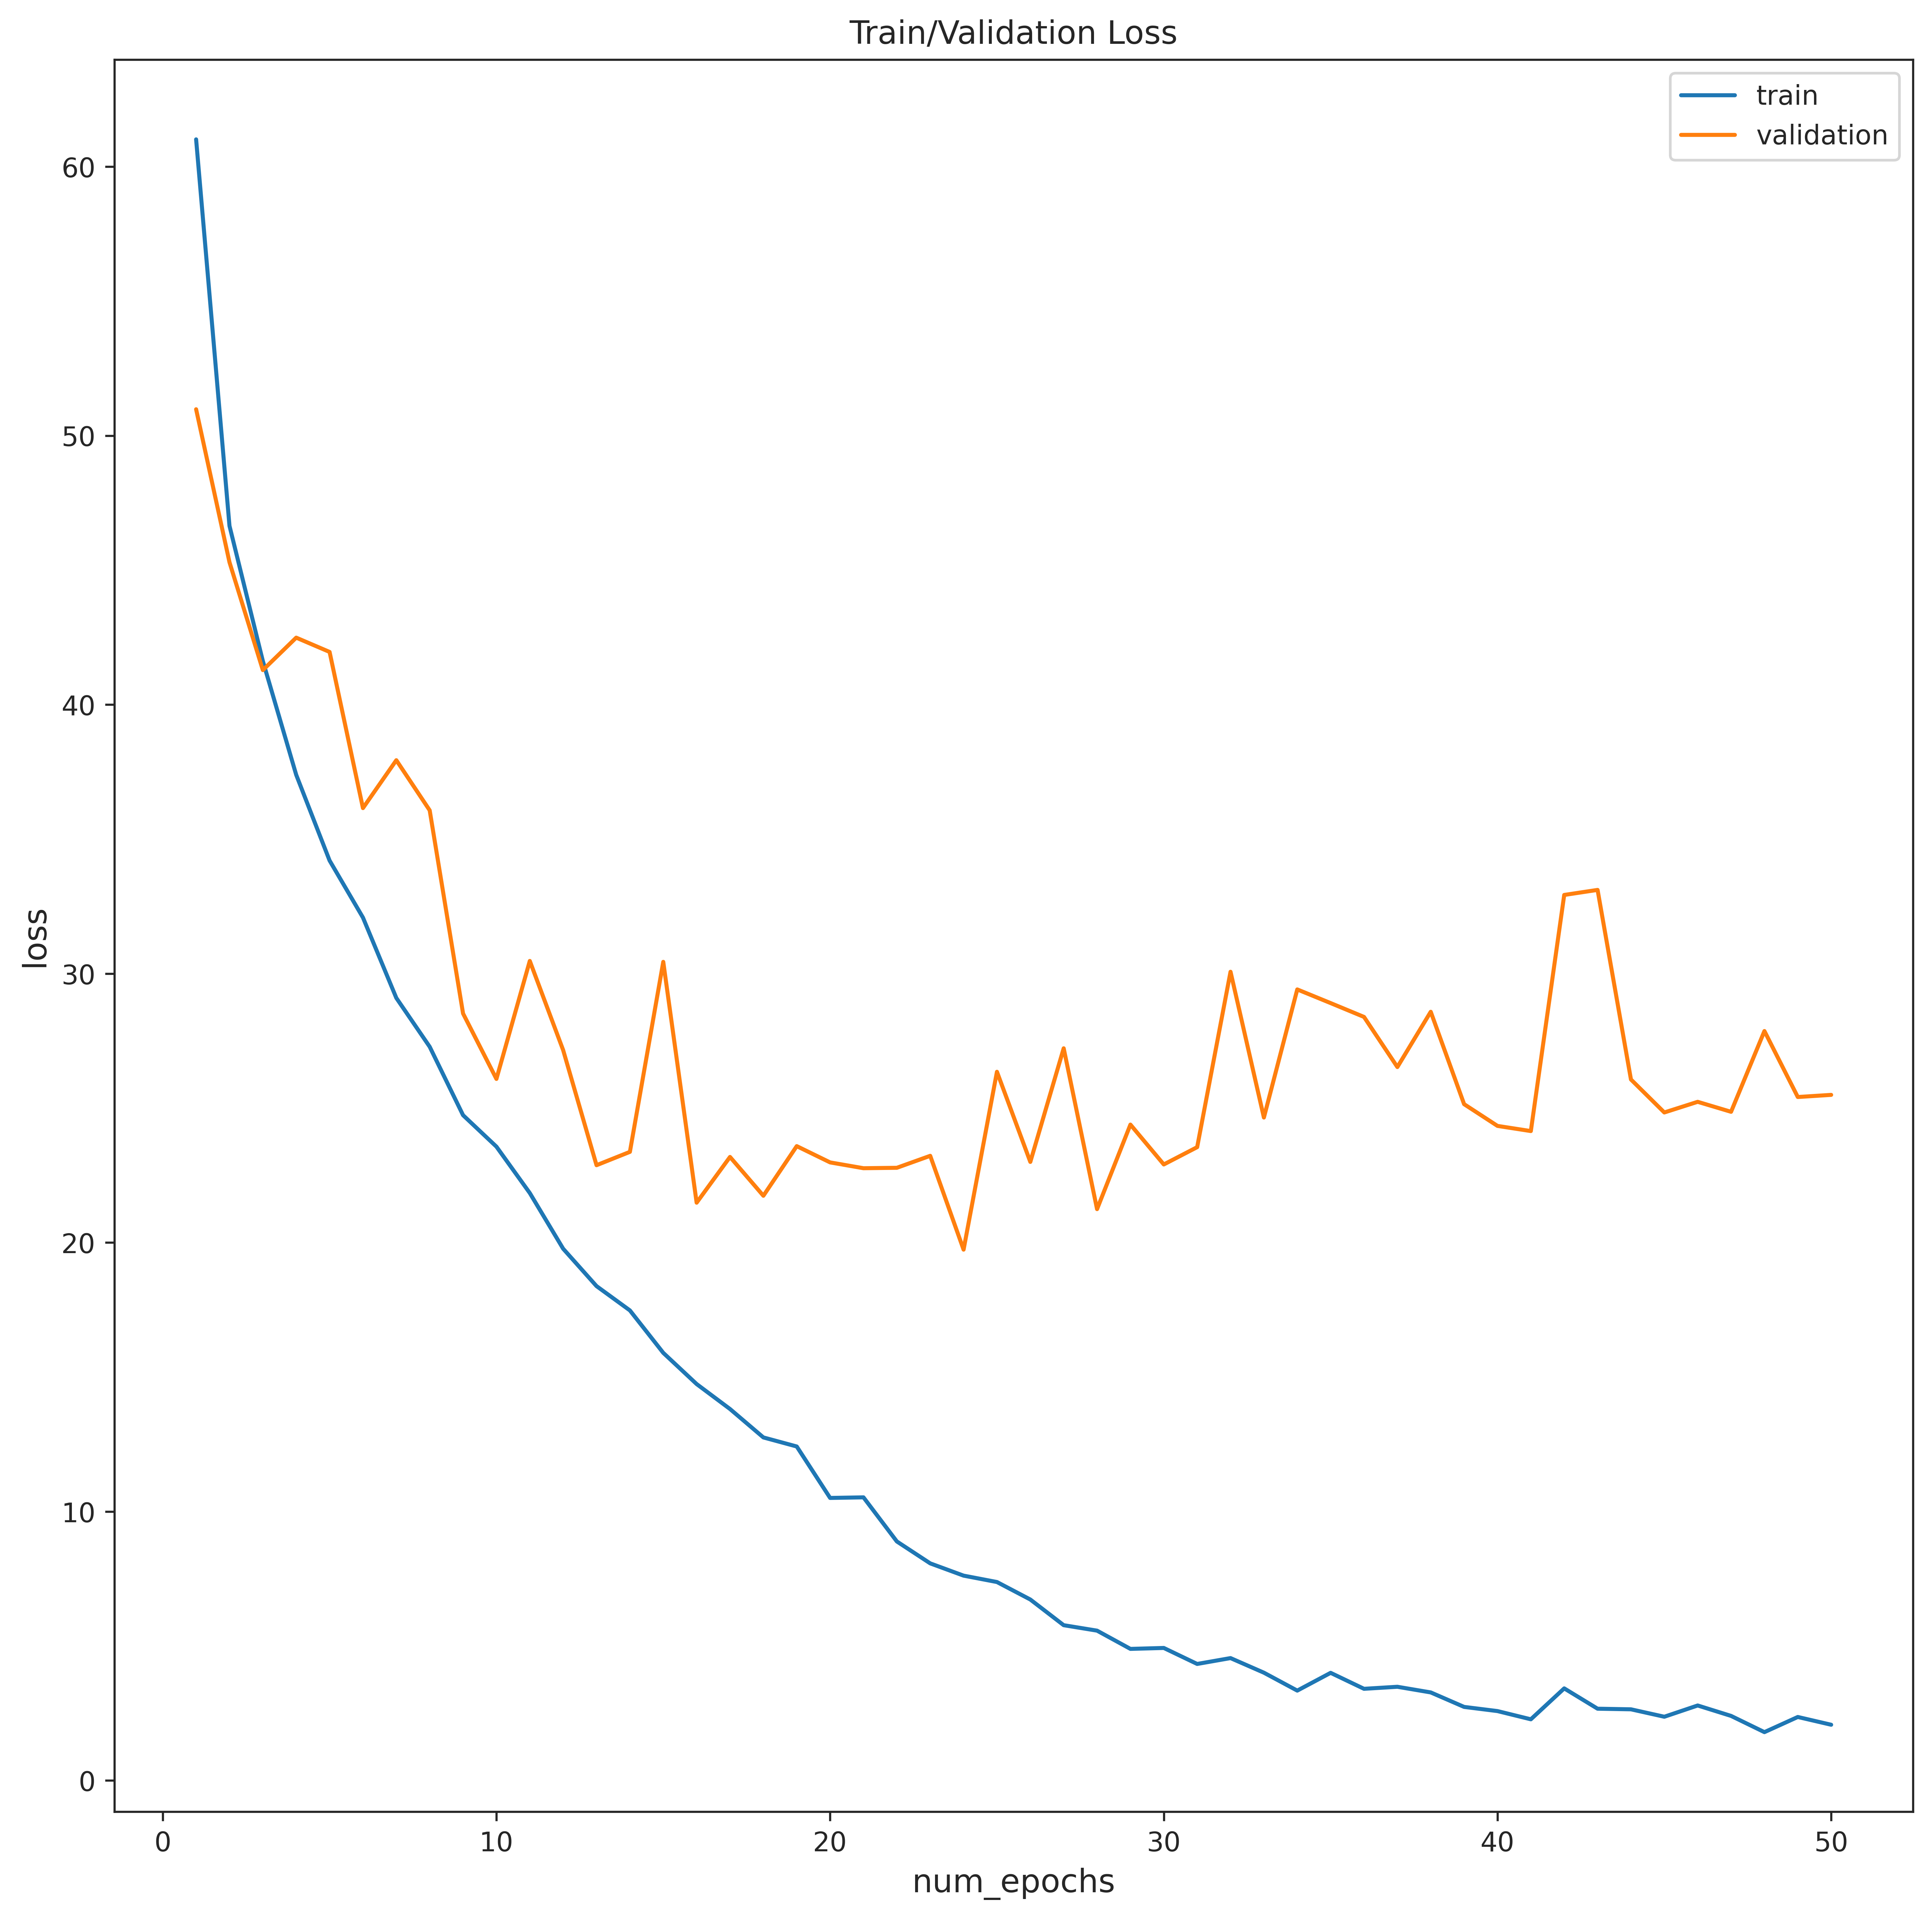

In [23]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

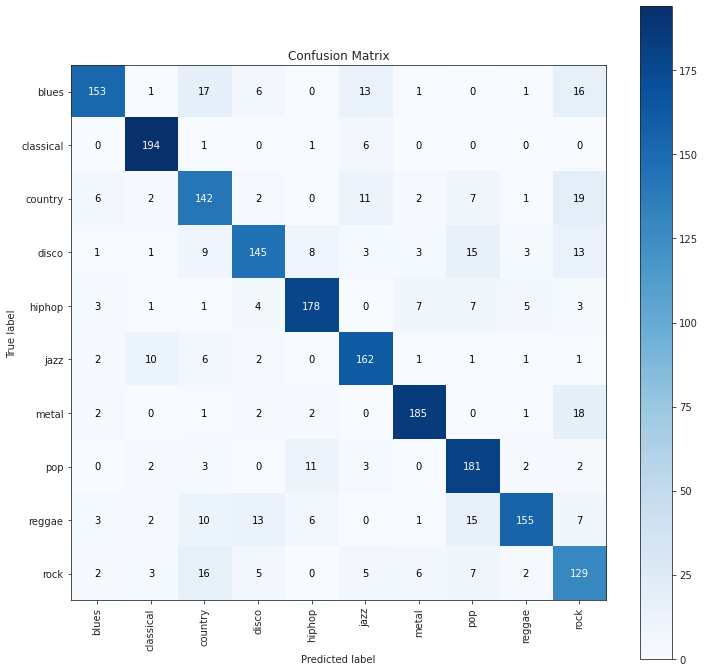

In [24]:
import scikitplot as skplt
y_true = [x for x in y_test_keep.tolist()]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       blues       0.89      0.74      0.81       208
   classical       0.90      0.96      0.93       202
     country       0.69      0.74      0.71       192
       disco       0.81      0.72      0.76       201
      hiphop       0.86      0.85      0.86       209
        jazz       0.80      0.87      0.83       186
       metal       0.90      0.88      0.89       211
         pop       0.78      0.89      0.83       204
      reggae       0.91      0.73      0.81       212
        rock       0.62      0.74      0.67       175

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000

